In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, mean_squared_error,mean_absolute_error
import pickle

## Objective
The objective of this project is to analyze Indian Premier League (IPL) match and ball-by-ball data to uncover insights about team and player performance. In addition, machine learning models are developed to predict match outcomes as well as individual player performance such as batsman runs and bowler wickets.

In [2]:
deliveries = pd.read_csv("deliveries.csv")
matches = pd.read_csv("matches.csv")

## Dataset Description
The project uses two datasets:
- `matches.csv`: Match-level information such as teams, venue, toss details, and match result.
- `deliveries.csv`: Ball-by-ball details including runs, wickets, batsman, and bowler information.

These datasets are merged using match identifiers to enable both match-level and player-level analysis.

In [3]:
df = pd.merge(
    deliveries,
    matches,
    left_on="match_id",
    right_on="id",
    how="inner"
)

In [4]:
df.head()

,match_id,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,...,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2
0,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,1,SC Ganguly,P Kumar,BB McCullum,0,...,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen
1,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,2,BB McCullum,P Kumar,SC Ganguly,0,...,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen
2,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,3,BB McCullum,P Kumar,SC Ganguly,0,...,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen
3,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,4,BB McCullum,P Kumar,SC Ganguly,0,...,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen
4,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,5,BB McCullum,P Kumar,SC Ganguly,0,...,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen


In [5]:
df.shape

(260920, 37)

In [6]:
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260920 entries, 0 to 260919
Data columns (total 37 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   match_id          260920 non-null  int64  
 1   inning            260920 non-null  int64  
 2   batting_team      260920 non-null  object 
 3   bowling_team      260920 non-null  object 
 4   over              260920 non-null  int64  
 5   ball              260920 non-null  int64  
 6   batter            260920 non-null  object 
 7   bowler            260920 non-null  object 
 8   non_striker       260920 non-null  object 
 9   batsman_runs      260920 non-null  int64  
 10  extra_runs        260920 non-null  int64  
 11  total_runs        260920 non-null  int64  
 12  extras_type       14125 non-null   object 
 13  is_wicket         260920 non-null  int64  
 14  player_dismissed  12950 non-null   object 
 15  dismissal_kind    12950 non-null   object 
 16  fielder           93

match_id                 0
inning                   0
batting_team             0
bowling_team             0
over                     0
ball                     0
batter                   0
bowler                   0
non_striker              0
batsman_runs             0
extra_runs               0
total_runs               0
extras_type         246795
is_wicket                0
player_dismissed    247970
dismissal_kind      247970
fielder             251566
id                       0
season                   0
city                 12397
date                     0
match_type               0
player_of_match        490
venue                    0
team1                    0
team2                    0
toss_winner              0
toss_decision            0
winner                 490
result                   0
result_margin         4124
target_runs            309
target_overs           309
super_over               0
method              257274
umpire1                  0
umpire2                  0
d

In [7]:
team_name_map = {
    'Delhi Daredevils': 'Delhi Capitals',
    'Punjab Kings': 'Kings XI Punjab',
    'Rising Pune Supergiant': 'Rising Pune Supergiants',
    'Royal Challengers Bangalore': 'Royal Challengers Bengaluru'
}

for col in ["batting_team", "bowling_team", "team1", "team2", "toss_winner", "winner"]:
    df[col] = df[col].replace(team_name_map)

In [8]:
df["batting_team"].unique()

array(['Kolkata Knight Riders', 'Royal Challengers Bengaluru',
       'Chennai Super Kings', 'Kings XI Punjab', 'Rajasthan Royals',
       'Delhi Capitals', 'Mumbai Indians', 'Deccan Chargers',
       'Kochi Tuskers Kerala', 'Pune Warriors', 'Sunrisers Hyderabad',
       'Rising Pune Supergiants', 'Gujarat Lions', 'Lucknow Super Giants',
       'Gujarat Titans'], dtype=object)

## Handling Missing Values

Several columns in the dataset contain missing values due to the nature of cricket matches. For example, dismissal-related columns are populated only when a wicket falls, and target-related columns are available only for second-innings matches.

Instead of dropping these rows, missing values are handled contextually:
- Categorical columns are filled with "Unknown"
- Numerical columns are filled with 0

This approach preserves important match information while ensuring compatibility with machine learning models.


In [9]:
categorial_cols = ["extras_type", "player_dismissed", "dismissal_kind", "fielder", "city",
                   "player_of_match", "winner", "method"]
df[categorial_cols] = df[categorial_cols].fillna("unknown")

In [10]:
num_cols =["result_margin", "target_runs", "target_overs"]
df[num_cols] = df[num_cols].fillna(0)

In [11]:
df["super_over"] = df["super_over"].map({'Y':1, 'N':0})

In [12]:
df.isna().sum()

match_id            0
inning              0
batting_team        0
bowling_team        0
over                0
ball                0
batter              0
bowler              0
non_striker         0
batsman_runs        0
extra_runs          0
total_runs          0
extras_type         0
is_wicket           0
player_dismissed    0
dismissal_kind      0
fielder             0
id                  0
season              0
city                0
date                0
match_type          0
player_of_match     0
venue               0
team1               0
team2               0
toss_winner         0
toss_decision       0
winner              0
result              0
result_margin       0
target_runs         0
target_overs        0
super_over          0
method              0
umpire1             0
umpire2             0
dtype: int64

In [13]:
df.head()

,match_id,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,...,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2
0,335982,1,Kolkata Knight Riders,Royal Challengers Bengaluru,0,1,SC Ganguly,P Kumar,BB McCullum,0,...,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,0,unknown,Asad Rauf,RE Koertzen
1,335982,1,Kolkata Knight Riders,Royal Challengers Bengaluru,0,2,BB McCullum,P Kumar,SC Ganguly,0,...,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,0,unknown,Asad Rauf,RE Koertzen
2,335982,1,Kolkata Knight Riders,Royal Challengers Bengaluru,0,3,BB McCullum,P Kumar,SC Ganguly,0,...,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,0,unknown,Asad Rauf,RE Koertzen
3,335982,1,Kolkata Knight Riders,Royal Challengers Bengaluru,0,4,BB McCullum,P Kumar,SC Ganguly,0,...,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,0,unknown,Asad Rauf,RE Koertzen
4,335982,1,Kolkata Knight Riders,Royal Challengers Bengaluru,0,5,BB McCullum,P Kumar,SC Ganguly,0,...,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,0,unknown,Asad Rauf,RE Koertzen


## Exploratory Data Analysis (EDA)

Exploratory analysis is performed to understand patterns in team performance, player contributions, and match outcomes. Visualizations are used to identify trends such as top-performing teams, leading run scorers, wicket takers, and the impact of the toss on match results.


In [14]:
top_10_batsman = df.groupby("batter")["batsman_runs"].sum().sort_values(ascending=False).head(10).reset_index()
top_10_batsman

,batter,batsman_runs
0,V Kohli,8014
1,S Dhawan,6769
2,RG Sharma,6630
3,DA Warner,6567
4,SK Raina,5536
5,MS Dhoni,5243
6,AB de Villiers,5181
7,CH Gayle,4997
8,RV Uthappa,4954
9,KD Karthik,4843


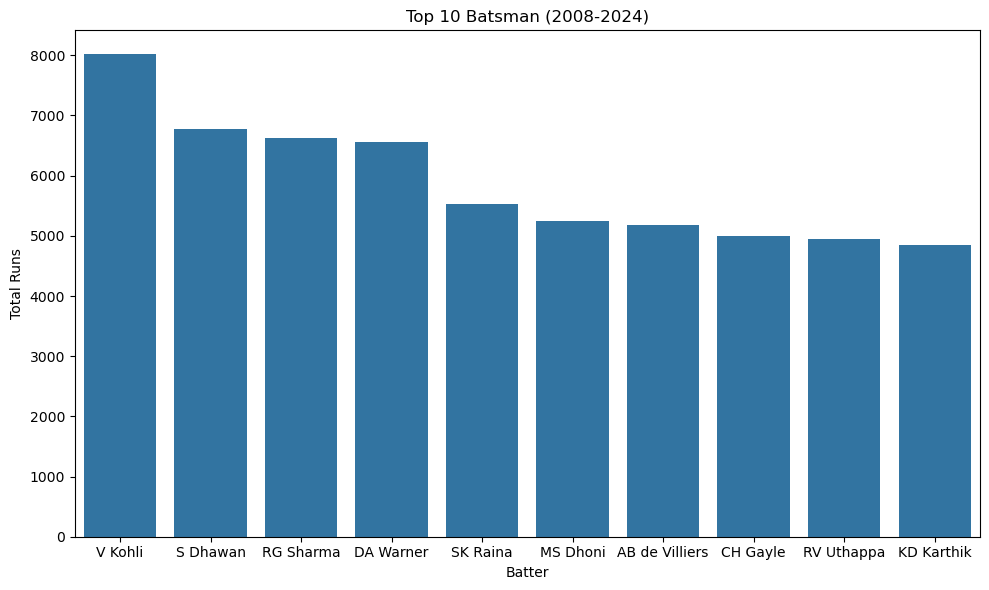

In [15]:
plt.figure(figsize=(10,6))

sns.barplot(
    top_10_batsman,
    x="batter",
    y="batsman_runs"
)
plt.xlabel("Batter")
plt.ylabel("Total Runs")
plt.title("Top 10 Batsman (2008-2024)")
plt.tight_layout()
plt.savefig("images/top_10_batsman.jpg")
plt.show()

**Insight:** The top run scorers have consistently performed across multiple seasons, demonstrating both skill and longevity in the tournament.


In [16]:
top_10_bowlers = df.groupby("bowler")["is_wicket"].sum().sort_values(ascending=False).reset_index().head(10)
top_10_bowlers

,bowler,is_wicket
0,YS Chahal,213
1,DJ Bravo,207
2,PP Chawla,201
3,SP Narine,200
4,R Ashwin,198
5,B Kumar,195
6,SL Malinga,188
7,A Mishra,183
8,JJ Bumrah,182
9,RA Jadeja,169


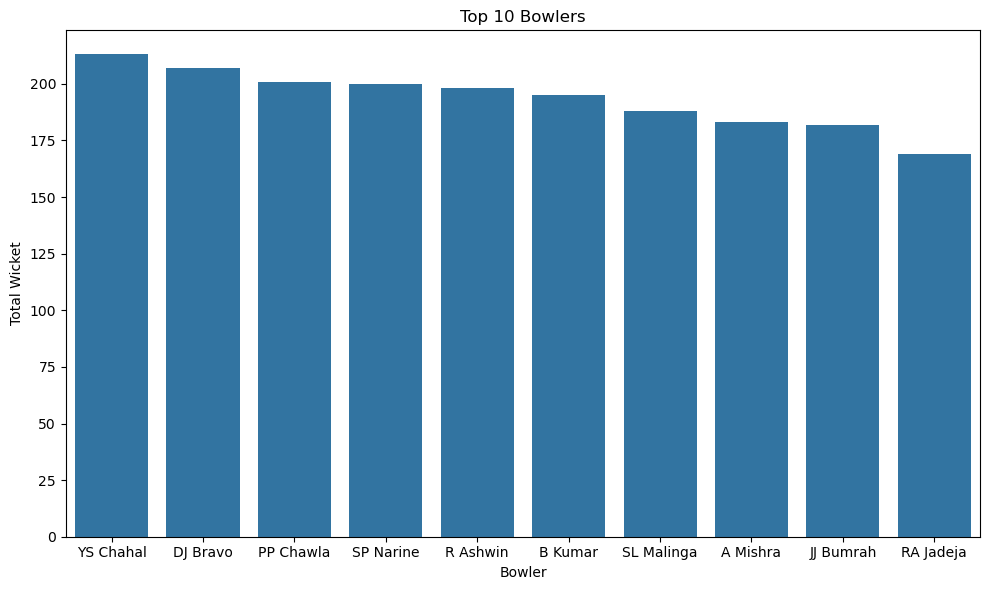

In [17]:
plt.figure(figsize=(10,6))

sns.barplot(
    top_10_bowlers,
    x="bowler",
    y="is_wicket"
)
plt.title("Top 10 Bowlers")
plt.xlabel("Bowler")
plt.ylabel("Total Wicket")
plt.tight_layout()
plt.savefig("images/top_10_bowlers.jpg")
plt.show()

**Insight:** Leading wicket takers are often strike bowlers who play key roles in multiple seasons, emphasizing the value of consistent bowling attacks.


In [18]:
top_10_most_catchers = df["fielder"].value_counts().sort_values(ascending=False).reset_index().head(10)
top_10_most_catchers = top_10_most_catchers.drop(index=0)
top_10_most_catchers

,fielder,count
1,MS Dhoni,220
2,KD Karthik,199
3,AB de Villiers,141
4,RV Uthappa,133
5,V Kohli,131
6,WP Saha,131
7,SK Raina,119
8,RA Jadeja,116
9,SV Samson,115


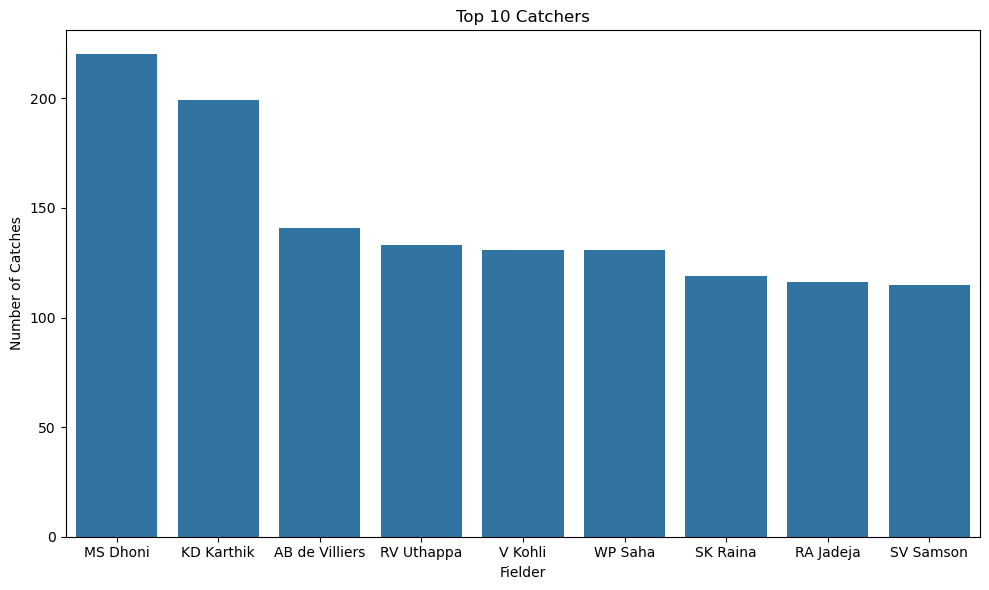

In [19]:
plt.figure(figsize=(10,6))

sns.barplot(
    top_10_most_catchers,
    x="fielder",
    y="count"
)
plt.xlabel("Fielder")
plt.ylabel("Number of Catches")
plt.title("Top 10 Catchers")
plt.tight_layout()
plt.savefig("images/top_10_catchers.jpg")
plt.show()

**Insight:** Certain players consistently contribute through fielding, showing that impact in IPL extends beyond batting and bowling performances.


In [20]:
matches_win_by_teams = matches["winner"].value_counts().sort_values(ascending=False).reset_index().head(10)
matches_win_by_teams

,winner,count
0,Mumbai Indians,144
1,Chennai Super Kings,138
2,Kolkata Knight Riders,131
3,Royal Challengers Bangalore,116
4,Rajasthan Royals,112
5,Sunrisers Hyderabad,88
6,Kings XI Punjab,88
7,Delhi Daredevils,67
8,Delhi Capitals,48
9,Deccan Chargers,29


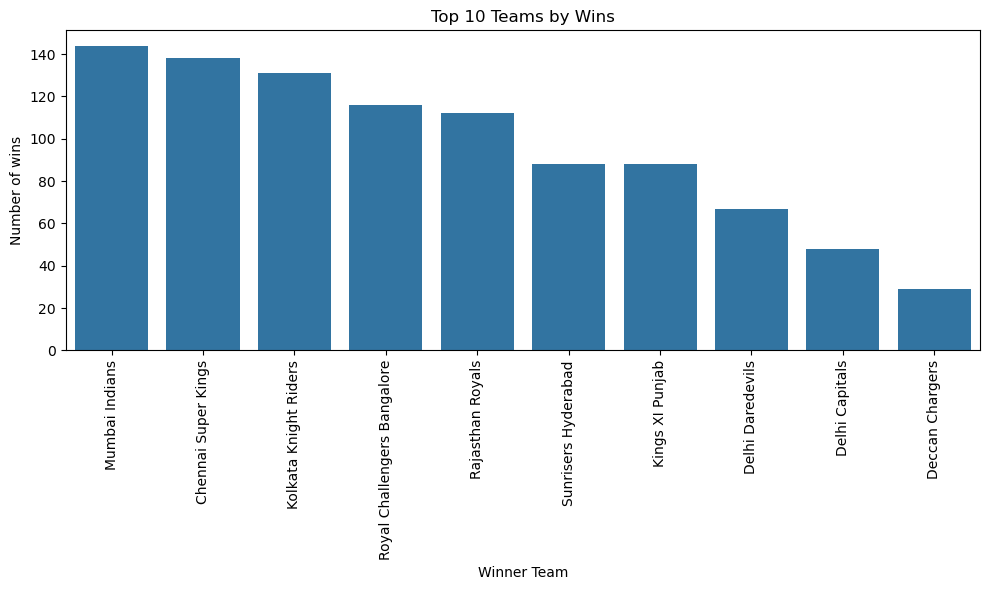

In [21]:
plt.figure(figsize=(10,6))

sns.barplot(
    matches_win_by_teams,
    x="winner",
    y="count"
)
plt.xlabel("Winner Team")
plt.ylabel("Number of wins")
plt.title("Top 10 Teams by Wins")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("images/top_10_teams_by_wins.jpg")
plt.show()

**Insight:** A small number of teams dominate the win count, indicating consistent long-term performance and effective team management across seasons.


In [22]:
matches_win_df = df.drop_duplicates(subset='id')
matches_win_df.head()

,match_id,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,...,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2
0,335982,1,Kolkata Knight Riders,Royal Challengers Bengaluru,0,1,SC Ganguly,P Kumar,BB McCullum,0,...,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,0,unknown,Asad Rauf,RE Koertzen
225,335983,1,Chennai Super Kings,Kings XI Punjab,0,1,PA Patel,B Lee,ML Hayden,0,...,bat,Chennai Super Kings,runs,33.0,241.0,20.0,0,unknown,MR Benson,SL Shastri
473,335984,1,Rajasthan Royals,Delhi Capitals,0,1,T Kohli,GD McGrath,YK Pathan,0,...,bat,Delhi Capitals,wickets,9.0,130.0,20.0,0,unknown,Aleem Dar,GA Pratapkumar
692,335985,1,Mumbai Indians,Royal Challengers Bengaluru,0,1,L Ronchi,P Kumar,ST Jayasuriya,0,...,bat,Royal Challengers Bengaluru,wickets,5.0,166.0,20.0,0,unknown,SJ Davis,DJ Harper
938,335986,1,Deccan Chargers,Kolkata Knight Riders,0,1,AC Gilchrist,AB Dinda,Y Venugopal Rao,1,...,bat,Kolkata Knight Riders,wickets,5.0,111.0,20.0,0,unknown,BF Bowden,K Hariharan


In [23]:
teams_win_1st_inning_df = matches_win_df[matches_win_df["batting_team"] == matches_win_df["winner"]]
teams_win_batting_first  = teams_win_1st_inning_df["winner"].value_counts().sort_values(ascending=False).reset_index()
teams_win_batting_first 

,winner,count
0,Mumbai Indians,72
1,Chennai Super Kings,70
2,Royal Challengers Bengaluru,58
3,Kolkata Knight Riders,53
4,Kings XI Punjab,51
5,Delhi Capitals,48
6,Rajasthan Royals,45
7,Sunrisers Hyderabad,44
8,Deccan Chargers,18
9,Lucknow Super Giants,16


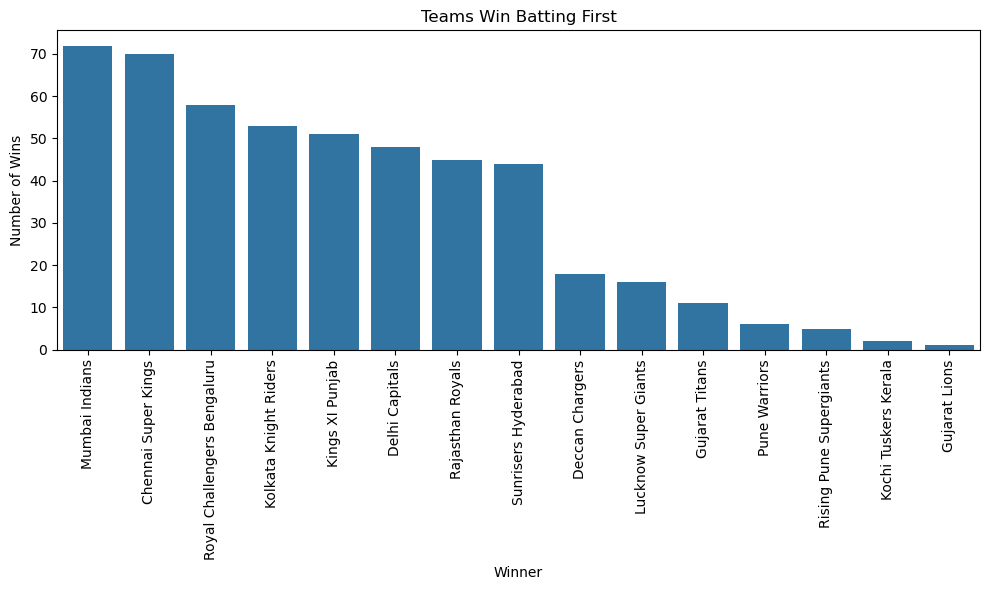

In [24]:
plt.figure(figsize=(10,6))

sns.barplot(
    teams_win_batting_first,
    x="winner",
    y="count"
)
plt.xlabel("Winner")
plt.ylabel("Number of Wins")
plt.title("Teams Win Batting First")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("images/teams_win_bat_first.jpg")
plt.show()

In [25]:
toss_winning_match_winning_df = matches[matches["toss_winner"] == matches["winner"]]
toss_winning_match_winning = toss_winning_match_winning_df["winner"].value_counts().sort_values(ascending=False).reset_index()
toss_winning_match_winning

,winner,count
0,Mumbai Indians,78
1,Chennai Super Kings,75
2,Kolkata Knight Riders,68
3,Rajasthan Royals,60
4,Royal Challengers Bangalore,57
5,Sunrisers Hyderabad,38
6,Kings XI Punjab,36
7,Delhi Daredevils,35
8,Delhi Capitals,26
9,Deccan Chargers,19


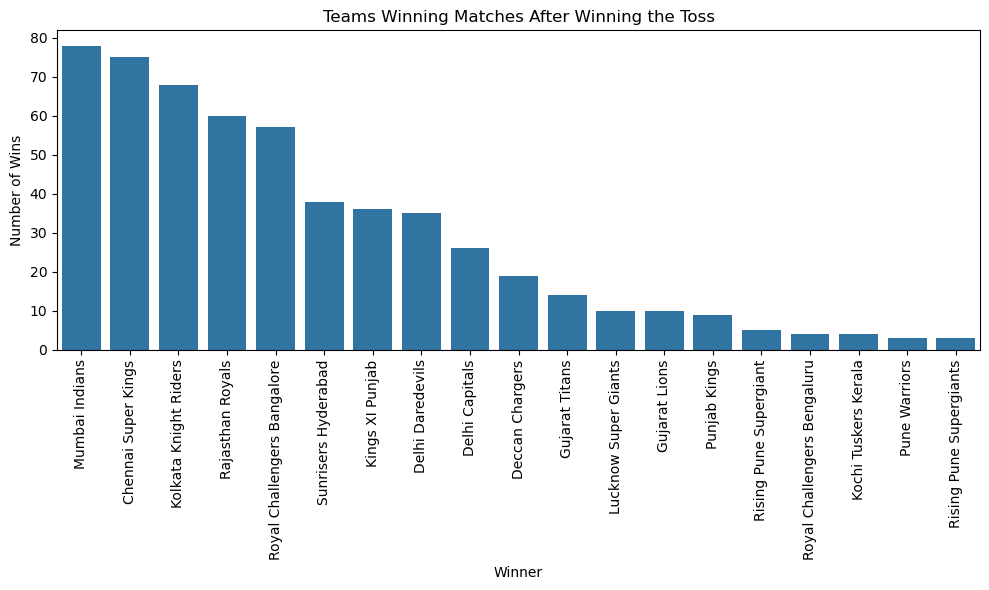

In [26]:
plt.figure(figsize=(10,6))

sns.barplot(
    toss_winning_match_winning,
    x="winner",
    y="count"
)
plt.xlabel("Winner")
plt.ylabel("Number of Wins")
plt.title("Teams Winning Matches After Winning the Toss")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("images/toss_win_match_win.jpg")
plt.show()

In [27]:
matches["toss_match_win"] = matches["winner"] == matches["toss_winner"]

In [28]:
toss_match_win = matches["toss_match_win"].value_counts()
toss_match_win

toss_match_win
True     554
False    541
Name: count, dtype: int64

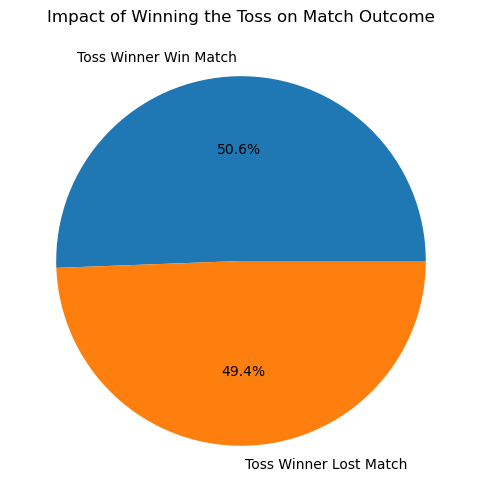

In [29]:
labels = ["Toss Winner Win Match", "Toss Winner Lost Match"]

plt.figure(figsize=(6,6))
plt.pie(
    toss_match_win,
    labels=labels,
    autopct="%1.1f%%"
)
plt.title("Impact of Winning the Toss on Match Outcome")
plt.savefig("images/toss_winner.jpg")
plt.show()

**Insight:** While winning the toss provides a strategic advantage, the visualization shows that it does not guarantee match victory, highlighting the importance of on-field performance.


In [30]:
team_home_city = {
    "Mumbai Indians": "Mumbai",
    "Chennai Super Kings": "Chennai",
    "Kolkata Knight Riders": "Kolkata",
    "Royal Challengers Bangalore": "Bangalore",
    "Delhi Capitals": "Delhi",
    "Rajasthan Royals": "Jaipur",
    "Sunrisers Hyderabad": "Hyderabad",
    "Punjab Kings": "Chandigarh"
}


In [31]:
matches["home_team"] = matches.apply(
    lambda x: x["team1"] if team_home_city.get(x["team1"]) == x["city"]
    else x["team2"] if team_home_city.get(x["team2"]) == x["city"]
    else "Neutral",
    axis=1
)

In [32]:
matches["home_wins"] = matches["home_team"] == matches["winner"]

In [33]:
home_match_wins = matches["home_wins"].value_counts()
home_match_wins

home_wins
False    816
True     279
Name: count, dtype: int64

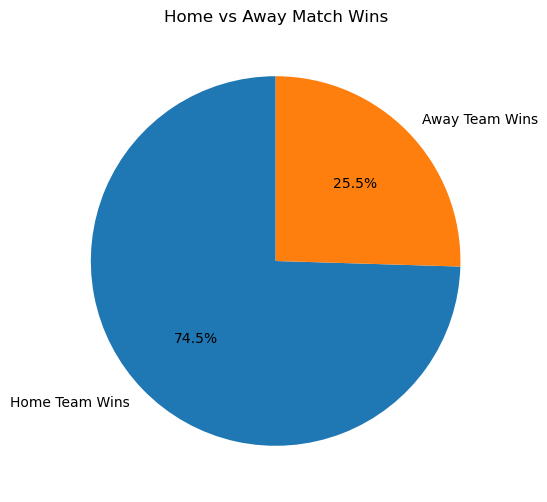

In [34]:
labels = ["Home Team Wins", "Away Team Wins"]

plt.figure(figsize=(6,6))
plt.pie(
    home_match_wins,
    labels=labels,
    autopct="%1.1f%%",
    startangle=90
)
plt.title("Home vs Away Match Wins")
plt.savefig("images/home_vs_away_wins.jpg")
plt.show()

**Insight:** Home teams tend to win more matches than away teams, indicating the presence of home advantage due to familiarity with pitch and conditions.


In [35]:
home_win_df = matches[matches["home_wins"] == True]
home_match_win_count =home_win_df["team1"].value_counts().reset_index()
home_match_win_count

,team1,count
0,Mumbai Indians,53
1,Kolkata Knight Riders,52
2,Chennai Super Kings,47
3,Rajasthan Royals,36
4,Royal Challengers Bangalore,35
5,Sunrisers Hyderabad,32
6,Delhi Capitals,7
7,Punjab Kings,4
8,Kings XI Punjab,3
9,Royal Challengers Bengaluru,3


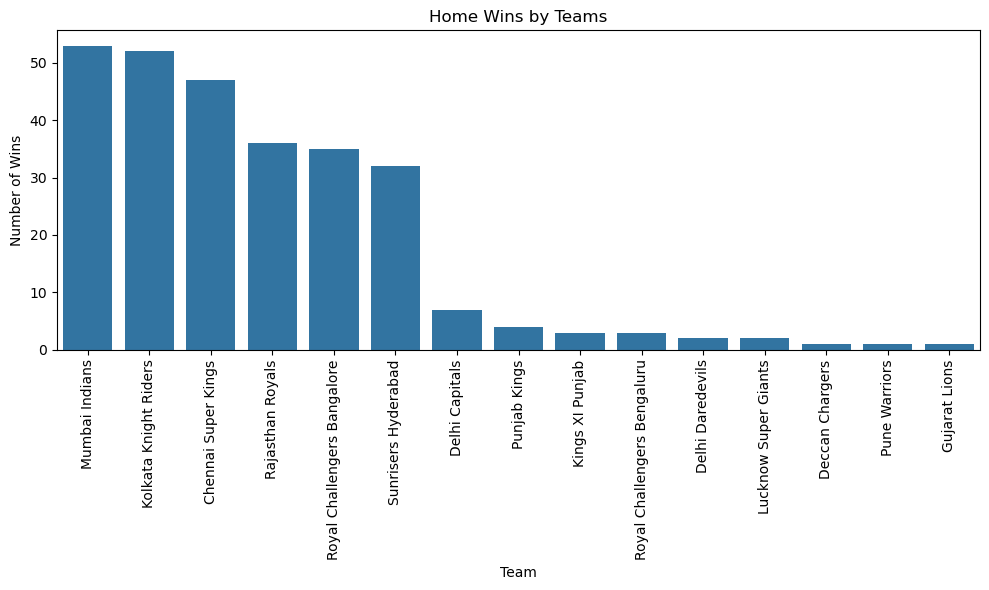

In [36]:
plt.figure(figsize=(10,6))

sns.barplot(
    home_match_win_count,
    x="team1",
    y="count"
)
plt.xlabel("Team")
plt.ylabel("Number of Wins")
plt.title("Home Wins by Teams")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("images/home_wins.jpg")
plt.show()

**Insight:** Some teams demonstrate strong home dominance, indicating effective utilization of familiar playing conditions.


In [37]:
top_10_six_hitters = df[df["batsman_runs"] == 6].groupby("batter").size().sort_values(ascending=False).reset_index().head(10)
top_10_six_hitters.columns = ["batter", "sixes"]
top_10_six_hitters

,batter,sixes
0,CH Gayle,359
1,RG Sharma,281
2,V Kohli,273
3,AB de Villiers,253
4,MS Dhoni,252
5,DA Warner,236
6,KA Pollard,224
7,AD Russell,209
8,SV Samson,206
9,SK Raina,204


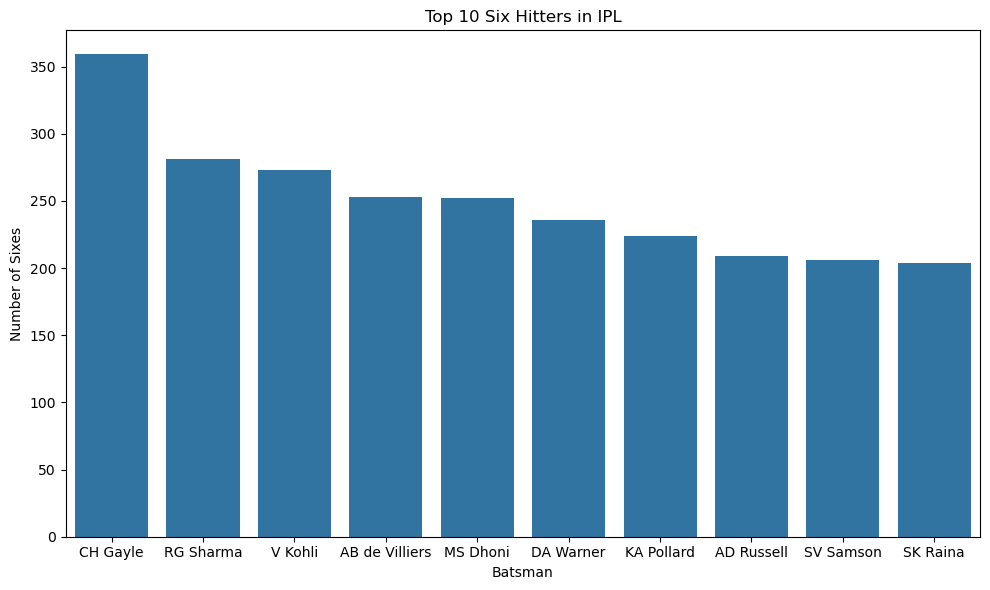

In [38]:
plt.figure(figsize=(10,6))

sns.barplot(
    top_10_six_hitters,
    x="batter",
    y="sixes"
)
plt.xlabel("Batsman")
plt.ylabel("Number of Sixes")
plt.title("Top 10 Six Hitters in IPL")
plt.tight_layout()
plt.savefig("images/top_10_sixer.jpg")
plt.show()

In [39]:
top_10_four_hitters = df[df["batsman_runs"] == 4].groupby("batter").size().sort_values(ascending=False).reset_index().head(10)
top_10_four_hitters.columns = ["batter", "fours"]
top_10_four_hitters

,batter,fours
0,S Dhawan,768
1,V Kohli,708
2,DA Warner,663
3,RG Sharma,599
4,SK Raina,506
5,G Gambhir,492
6,RV Uthappa,481
7,AM Rahane,479
8,KD Karthik,466
9,F du Plessis,422


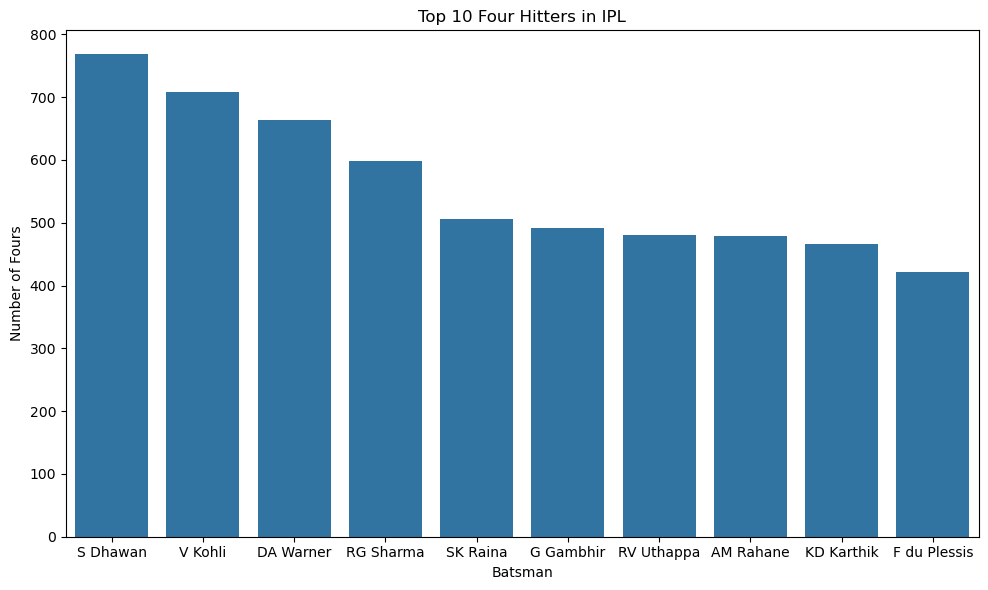

In [40]:
plt.figure(figsize=(10,6))

sns.barplot(
    top_10_four_hitters,
    x="batter",
    y="fours"
)
plt.xlabel("Batsman")
plt.ylabel("Number of Fours")
plt.title("Top 10 Four Hitters in IPL")
plt.tight_layout()
plt.savefig("images/top_10_four.jpg")
plt.show()

In [41]:
total_runs_by_teams = df.groupby("batting_team")["total_runs"].sum().sort_values(ascending=False).reset_index()
total_runs_by_teams

,batting_team,total_runs
0,Mumbai Indians,42176
1,Royal Challengers Bengaluru,40622
2,Kings XI Punjab,39600
3,Kolkata Knight Riders,39331
4,Delhi Capitals,39196
5,Chennai Super Kings,38629
6,Rajasthan Royals,34747
7,Sunrisers Hyderabad,29071
8,Deccan Chargers,11463
9,Gujarat Titans,7757


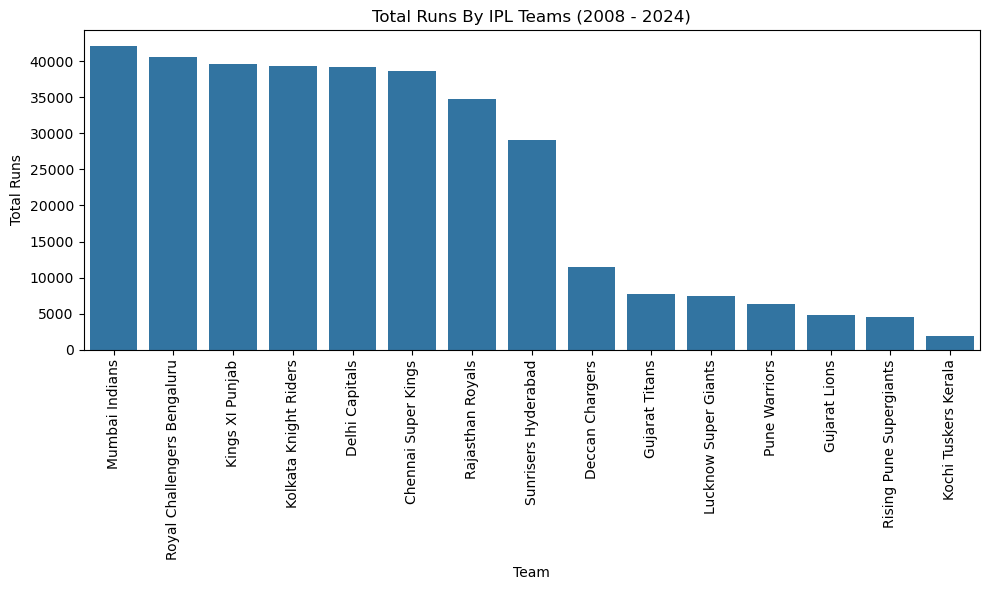

In [42]:
plt.figure(figsize=(10,6))

sns.barplot(
    total_runs_by_teams,
    x="batting_team",
    y="total_runs"
)
plt.xlabel("Team")
plt.ylabel("Total Runs")
plt.title("Total Runs By IPL Teams (2008 - 2024)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("images/total_runs_by_teams.jpg")
plt.show()

## Match Winner Prediction

A machine learning classification model is developed to predict the winner of an IPL match using only pre-match information such as participating teams, venue, toss winner, and toss decision. Using only pre-match features avoids data leakage and ensures realistic predictions.


In [43]:
matches_df = matches.copy()

In [44]:
matches_df = matches_df[matches_df["winner"].notna()]
y = matches_df["winner"]
y.isna().sum()

np.int64(0)

In [45]:
X = matches_df[["venue", "team1", "team2", "toss_winner", "toss_decision"]]

In [46]:
categorial_cols = X.columns

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown='ignore'), categorial_cols)
    ]
)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [48]:
log_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("lr", LogisticRegression())
])
log_model.fit(X_train, y_train)

y_pred = log_model.predict(X_test)

print("Accuracy Score: ", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))

Accuracy Score:  0.555045871559633
Classification Report:
                              precision    recall  f1-score   support

        Chennai Super Kings       0.62      0.65      0.63        37
            Deccan Chargers       0.50      0.50      0.50         2
             Delhi Capitals       0.38      0.43      0.40         7
           Delhi Daredevils       0.64      0.54      0.58        13
              Gujarat Lions       1.00      0.40      0.57         5
             Gujarat Titans       0.80      0.44      0.57         9
            Kings XI Punjab       0.44      0.47      0.46        17
       Kochi Tuskers Kerala       0.00      0.00      0.00         2
      Kolkata Knight Riders       0.54      0.61      0.57        23
       Lucknow Super Giants       0.50      0.67      0.57         3
             Mumbai Indians       0.48      0.58      0.53        26
              Pune Warriors       0.50      0.33      0.40         3
               Punjab Kings       0.00     

In [49]:
rf_model = Pipeline([
    ("preprocessor", preprocessor),
    ("rfc", RandomForestClassifier(
        n_estimators=501,
        random_state=42
    ))
])
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

print("Accuracy Score: ", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))

Accuracy Score:  0.5137614678899083
Classification Report:
                              precision    recall  f1-score   support

        Chennai Super Kings       0.56      0.59      0.58        37
            Deccan Chargers       0.67      1.00      0.80         2
             Delhi Capitals       0.25      0.14      0.18         7
           Delhi Daredevils       0.50      0.46      0.48        13
              Gujarat Lions       0.50      0.40      0.44         5
             Gujarat Titans       0.71      0.56      0.62         9
            Kings XI Punjab       0.44      0.47      0.46        17
       Kochi Tuskers Kerala       0.00      0.00      0.00         2
      Kolkata Knight Riders       0.50      0.57      0.53        23
       Lucknow Super Giants       0.50      1.00      0.67         3
             Mumbai Indians       0.50      0.58      0.54        26
              Pune Warriors       0.00      0.00      0.00         3
               Punjab Kings       0.00    

In [50]:
depths = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for depth in depths:
    dt_model = Pipeline([
        ("preprocessor", preprocessor),
        ("dtc", DecisionTreeClassifier(
            max_depth=depth
        ))
    ])
    dt_model.fit(X_train, y_train)

    y_pred = dt_model.predict(X_test)
    print(f"Accuracy Score for depth {depth}: ", accuracy_score(y_test, y_pred))
    print(f"F1 Score for depth {depth}: ", f1_score(y_test, y_pred, average="weighted", zero_division=0))

Accuracy Score for depth 2:  0.21100917431192662
F1 Score for depth 2:  0.10859710918270357
Accuracy Score for depth 3:  0.2798165137614679
F1 Score for depth 3:  0.22082319623752
Accuracy Score for depth 4:  0.3394495412844037
F1 Score for depth 4:  0.27863739896735196
Accuracy Score for depth 5:  0.3944954128440367
F1 Score for depth 5:  0.31242157416927197
Accuracy Score for depth 6:  0.3761467889908257
F1 Score for depth 6:  0.32354140639482865
Accuracy Score for depth 7:  0.43119266055045874
F1 Score for depth 7:  0.3788447547883573
Accuracy Score for depth 8:  0.44954128440366975
F1 Score for depth 8:  0.40010309795310955
Accuracy Score for depth 9:  0.44495412844036697
F1 Score for depth 9:  0.4061236028519245
Accuracy Score for depth 10:  0.4541284403669725
F1 Score for depth 10:  0.4261905439318241


### Model Evaluation

The model is evaluated using accuracy and weighted F1-score. Weighted F1-score is preferred due to class imbalance among teams, ensuring that teams with fewer matches do not disproportionately affect the evaluation.

The results indicate that while winning the toss provides a strategic advantage, it does not guarantee match victory.


In [51]:
best_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("lr", LogisticRegression())
])
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

print("Accuracy Score: ", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))

Accuracy Score:  0.555045871559633
Classification Report:
                              precision    recall  f1-score   support

        Chennai Super Kings       0.62      0.65      0.63        37
            Deccan Chargers       0.50      0.50      0.50         2
             Delhi Capitals       0.38      0.43      0.40         7
           Delhi Daredevils       0.64      0.54      0.58        13
              Gujarat Lions       1.00      0.40      0.57         5
             Gujarat Titans       0.80      0.44      0.57         9
            Kings XI Punjab       0.44      0.47      0.46        17
       Kochi Tuskers Kerala       0.00      0.00      0.00         2
      Kolkata Knight Riders       0.54      0.61      0.57        23
       Lucknow Super Giants       0.50      0.67      0.57         3
             Mumbai Indians       0.48      0.58      0.53        26
              Pune Warriors       0.50      0.33      0.40         3
               Punjab Kings       0.00     

In [52]:
with open("match_pred.pkl", "wb") as f:
    pickle.dump(best_model, f)
print("Model saved successfully!")

Model saved successfully!


## Batsman Performance Prediction

To predict a batsman’s performance in the next match, match-level aggregates are created for each batsman. Rolling averages of runs from the last 5 and 10 matches are used to capture recent form. Targets are shifted temporally to ensure that only past information is used for prediction, preventing data leakage.


In [53]:
batsman_match_runs = df.groupby(["id", "batter", "season", "batting_team", "bowling_team", "venue"])["batsman_runs"].sum().reset_index()
batsman_match_runs = batsman_match_runs.sort_values(by=["batter", "id"])
batsman_match_runs.shape

(16515, 7)

In [54]:
batsman_match_runs["avg_last_5"] = batsman_match_runs.groupby("batter")["batsman_runs"].rolling(5).mean().reset_index(level=0, drop=True)
batsman_match_runs["avg_last_10"] = batsman_match_runs.groupby("batter")["batsman_runs"].rolling(10).mean().reset_index(level=0, drop=True)

In [55]:
batsman_match_runs["next_match_runs"] = batsman_match_runs.groupby("batter")["batsman_runs"].shift(-1)

In [56]:
batsman_match_runs = batsman_match_runs.dropna()
batsman_match_runs.shape

(12020, 10)

In [57]:
batsman_match_runs.head()

,id,batter,season,batting_team,bowling_team,venue,batsman_runs,avg_last_5,avg_last_10,next_match_runs
5160,598018,A Ashish Reddy,2013,Sunrisers Hyderabad,Pune Warriors,Maharashtra Cricket Association Stadium,19,12.0,9.5,7.0
5213,598021,A Ashish Reddy,2013,Sunrisers Hyderabad,Kings XI Punjab,"Rajiv Gandhi International Stadium, Uppal",7,12.0,9.2,36.0
5341,598030,A Ashish Reddy,2013,Sunrisers Hyderabad,Chennai Super Kings,"MA Chidambaram Stadium, Chepauk",36,16.4,12.5,14.0
5370,598032,A Ashish Reddy,2013,Sunrisers Hyderabad,Rajasthan Royals,Sawai Mansingh Stadium,14,16.0,13.1,5.0
5539,598044,A Ashish Reddy,2013,Sunrisers Hyderabad,Delhi Capitals,"Rajiv Gandhi International Stadium, Uppal",5,16.2,12.6,3.0


In [58]:
batsman_latest_stats = (
    batsman_match_runs
    .dropna()
    .groupby("batter")
    .tail(1)
    [["batter", "avg_last_5", "avg_last_10"]]
)
batsman_latest_stats.to_csv(
    "batsman_match_stats.csv",
    index=False
)

In [59]:
X = batsman_match_runs[["avg_last_5", "avg_last_10", "bowling_team", "venue"]]
y = batsman_match_runs["next_match_runs"]

num_features = ["avg_last_5", "avg_last_10"]
cat_features = ["bowling_team", "venue"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="mean"), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)

In [60]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42
)

In [61]:
rfr_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=201,
        random_state=42
    ))
])
rfr_pipeline.fit(X_train, y_train)

y_pred = rfr_pipeline.predict(X_test)

print("MAE: ", mean_absolute_error(y_test, y_pred))

MAE:  16.870655221633694


In [62]:
lr_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("lr_model", LinearRegression())
])
lr_pipeline.fit(X_train, y_train)

y_pred = lr_pipeline.predict(X_test)

print("MAE: ", mean_absolute_error(y_test, y_pred))

MAE:  16.498594714497038


### Model Comparison

Both Linear Regression and Random Forest models were evaluated. Linear Regression achieved a lower mean absolute error (MAE), indicating that batsman performance trends exhibit largely linear relationships given the current feature set.

This highlights that simpler models can outperform complex models when features are well-engineered.


In [63]:
with open("model.pkl", "wb") as f:
    pickle.dump(lr_pipeline, f)

print("Model saved successfully!")

Model saved successfully!


## Bowler Wicket Prediction

Bowler performance is analyzed at the match level by aggregating the number of wickets taken in each match. Rolling averages of recent wicket counts are used as predictive features, along with contextual information such as opponent team and venue.


In [64]:
bowler_match_wickets = df.groupby(["id", "bowler", "season", "batting_team", "bowling_team", "venue"])["is_wicket"].sum().reset_index()
bowler_match_wickets = bowler_match_wickets.sort_values(by=["bowler", "id"])
bowler_match_wickets.shape

(12978, 7)

In [65]:
bowler_match_wickets["avg_last_5"] = bowler_match_wickets.groupby("bowler")["is_wicket"].rolling(5).mean().reset_index(level=0, drop=True)
bowler_match_wickets["avg_last_10"] = bowler_match_wickets.groupby("bowler")["is_wicket"].rolling(10).mean().reset_index(level=0, drop=True)

In [66]:
bowler_match_wickets["next_match_wickets"] = bowler_match_wickets.groupby("bowler")["is_wicket"].shift(-1)

In [67]:
bowler_match_wickets = bowler_match_wickets.dropna()
bowler_match_wickets.head()

,id,bowler,season,batting_team,bowling_team,venue,is_wicket,avg_last_5,avg_last_10,next_match_wickets
3893,598000,A Ashish Reddy,2013,Pune Warriors,Sunrisers Hyderabad,"Rajiv Gandhi International Stadium, Uppal",1,1.4,1.2,1.0
3938,598004,A Ashish Reddy,2013,Royal Challengers Bengaluru,Sunrisers Hyderabad,"Rajiv Gandhi International Stadium, Uppal",1,1.4,1.3,1.0
4043,598013,A Ashish Reddy,2013,Kolkata Knight Riders,Sunrisers Hyderabad,Eden Gardens,1,1.2,1.2,0.0
4237,598030,A Ashish Reddy,2013,Chennai Super Kings,Sunrisers Hyderabad,"MA Chidambaram Stadium, Chepauk",0,1.2,1.1,0.0
4448,598048,A Ashish Reddy,2013,Royal Challengers Bengaluru,Sunrisers Hyderabad,M Chinnaswamy Stadium,0,0.6,1.0,1.0


In [68]:
bowler_latest_stats = (
    bowler_match_wickets
    .dropna()
    .groupby("bowler")
    .tail(1)
    [["bowler", "avg_last_5", "avg_last_10"]]
)
bowler_latest_stats.to_csv(
    "bowler_latest_stats.csv",
    index=False
)

In [69]:
X = bowler_match_wickets[["avg_last_5", "avg_last_10", "batting_team", "venue"]]
y = bowler_match_wickets["next_match_wickets"]

num_features = ["avg_last_5", "avg_last_10"]
cat_features = ["batting_team", "venue"]

preprcessor = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="mean"), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)

In [70]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [71]:
lr_pipeline = Pipeline([
    ("preprcessor", preprcessor),
    ("lr", LinearRegression())
])
lr_pipeline.fit(X_train, y_train)

y_pred = lr_pipeline.predict(X_test)

print("MAE: ", mean_absolute_error(y_test, y_pred))

MAE:  0.8331743675903741


In [72]:
rf_pipeline = Pipeline([
    ("preprcessor", preprcessor),
    ("rfr", RandomForestRegressor(
        n_estimators=201,
        random_state=42
    ))
])
rf_pipeline.fit(X_train, y_train)

y_pred = rf_pipeline.predict(X_test)

print("MAE: ", mean_absolute_error(y_test, y_pred))

MAE:  0.8986344186183072


### Evaluation and Observations

The bowler prediction model demonstrates reasonable accuracy, with performance improving when recent form and contextual features are included. Variability in wicket-taking performance reflects the inherent uncertainty in cricket outcomes.


In [73]:
with open("bowler_model.pkl", "wb") as f:
    pickle.dump(lr_pipeline, f)
print("Model saved successfully!")

Model saved successfully!


## Model Deployment

The final trained models are serialized using pickle to enable deployment in a Streamlit application. Saving the entire preprocessing and modeling pipeline ensures consistency between training and inference stages.


## Limitations and Future Work

While the models demonstrate reasonable predictive performance, cricket outcomes are inherently uncertain. The models do not account for factors such as player injuries, pitch conditions, weather, or real-time match situations.

Future improvements may include:
- Incorporating batting position and bowling spells
- Adding pitch and weather data
- Using time-based cross-validation
- Predicting performance ranges instead of exact values


## Conclusion

This project demonstrates an end-to-end data science workflow applied to IPL cricket data, including data cleaning, exploratory analysis, feature engineering, model training, and deployment readiness. By emphasizing realistic evaluation and avoiding data leakage, the project provides reliable and interpretable insights into team and player performance.
